In [1]:
using FKTcheb
using SymPy
using TimerOutputs
using LinearAlgebra
using LowRankApprox
using Printf
using Random
using Plots
using Distributions
using StaticArrays
using Polynomials
using SpecialFunctions
using Combinatorics

┌ Info: Precompiling FKTcheb [8f6a1ce6-3be6-48da-82a4-714bd5a66102]
└ @ Base loading.jl:1317
┌ Warning: Package FKTcheb does not have Plots in its dependencies:
│ - If you have FKTcheb checked out for development and have
│   added Plots as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FKTcheb
└ Loading Plots into FKTcheb from project dependency, future warnings for FKTcheb are suppressed.


In [2]:
include("factor.jl")
include("util.jl")
include("gegenbauer.jl")
include("hyperspherical.jl")

hypospherical (generic function with 1 method)

In [110]:

# r = Sym("r")

# spread_param = 6
# dct_n         = 100 # Iterations for discrete cosine transform
# kern          = 1 / (1+r^2)
# mat_kern(x,y) = 1 / (1+norm(x-y)^2)
# lkern         = lambdify(kern)
# to            = TimerOutput()

# fkt_degs = fkt_degs

# results = Dict()
for num_points in 50000:50000:250000
    random_samp = randperm(num_points)[1:1000]
    for d in 3:4:15
        x_vecs = [randn(d) / spread_param for _ in 1:num_points]
        truth_mat  = mat_kern.(x_vecs[random_samp], permutedims(x_vecs[random_samp]))
        truemat_frobnorm = norm(truth_mat)
        for fkt_deg in 14:2:20
            GC.gc()
            println((num_points, d, fkt_deg))
            rtol = 10.0^(-15)
            cfg = fkt_config(fkt_deg, d, dct_n, to, rtol)
            rtol = guess_fkt_err(lkern, x_vecs, cfg)
            cfg = fkt_config(fkt_deg, d, dct_n, to, rtol)
            fkt_t = 0
            U_mat=0
            for k in 1:3
                fkt_t += @elapsed U_mat = degen_kern_harmonic(lkern, x_vecs, cfg)
            end
            fkt_t/=3
            V_mat = transpose(U_mat)
            fkt_rank = size(U_mat, 2)

            fkt_guess = U_mat[random_samp,:]*V_mat[:, random_samp]
            fkt_err = (norm(fkt_guess-truth_mat)
                            /truemat_frobnorm)
            results[(num_points, d, fkt_deg)] = (fkt_t, fkt_rank, fkt_err)
        end
    end
end



(50000, 3, 14)
Using interval [0,1.6227979244772313]
(50000, 3, 16)
Using interval [0,1.6227979244772313]
(50000, 3, 18)
Using interval [0,1.6227979244772313]
(50000, 3, 20)
Using interval [0,1.6227979244772313]
(50000, 7, 14)
Using interval [0,2.106722502292677]
(50000, 7, 16)
Using interval [0,2.106722502292677]
(50000, 7, 18)
Using interval [0,2.106722502292677]
(50000, 7, 20)
Using interval [0,2.106722502292677]
(50000, 11, 14)
Using interval [0,2.1714878307666607]
(50000, 11, 16)
Using interval [0,2.1714878307666607]
(50000, 11, 18)
Using interval [0,2.1714878307666607]
(50000, 11, 20)
Using interval [0,2.1714878307666607]
(50000, 15, 14)
Using interval [0,2.469308030479153]
(50000, 15, 16)
Using interval [0,2.469308030479153]
(50000, 15, 18)
Using interval [0,2.469308030479153]
(50000, 15, 20)
Using interval [0,2.469308030479153]
(100000, 3, 14)
Using interval [0,1.8107517579595445]
(100000, 3, 16)
Using interval [0,1.8107517579595445]
(100000, 3, 18)
Using interval [0,1.81075175

LoadError: InterruptException:

In [109]:
fkt_degs = collect(2:2:20)

10-element Vector{Int64}:
  2
  4
  6
  8
 10
 12
 14
 16
 18
 20

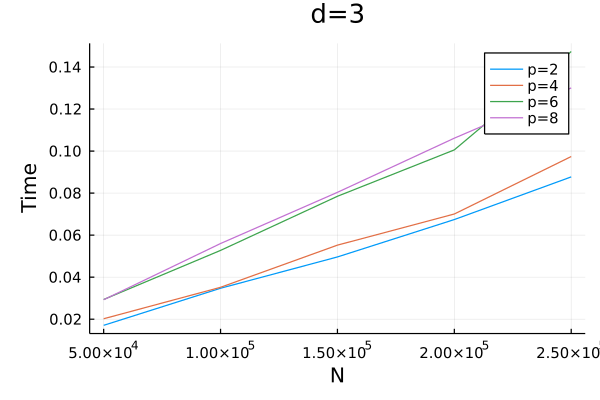

In [129]:
ns = collect(50000:50000:250000)
all_times = []
for p in fkt_degs[1:4]
    times = []
    for n in ns
        push!(times, results[(n, 3, p)][1])
    end
    push!(all_times, times)
end
p = plot(title="d=3", thickness_scaling = 1.25, xlabel="N", ylabel="Time")
for k in 1:length(all_times)
    p=plot!(ns, all_times[k], label=string("p=",2*k))
end
p

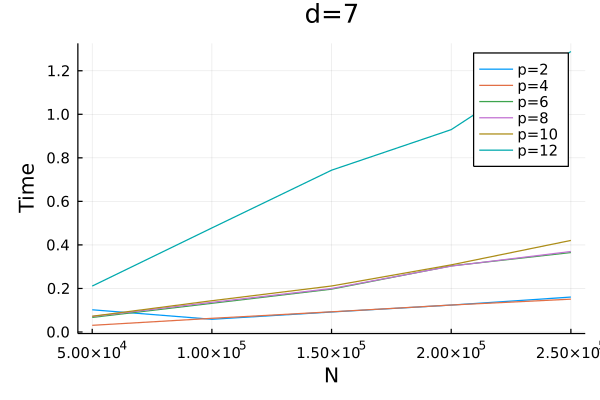

In [69]:
ns = collect(50000:50000:250000)
all_times = []
for p in fkt_degs
    times = []
    for n in ns
        push!(times, results[(n, 7, p)][1])
    end
    push!(all_times, times)
end
p = plot(title="d=7")
for k in 1:length(all_times)
    p=plot!(ns, all_times[k], label=string("p=",2*k), thickness_scaling = 1.25, xlabel="N", ylabel="Time")
end
p

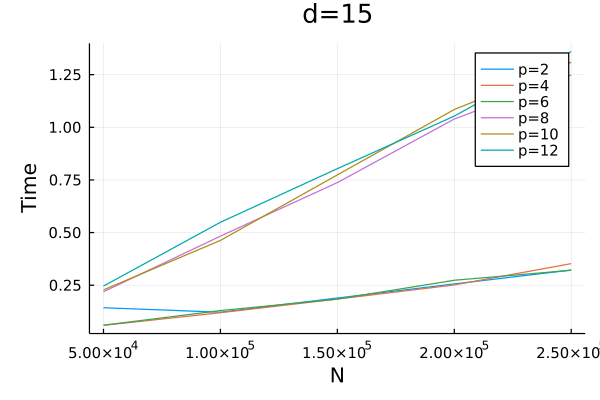

In [70]:
ns = collect(50000:50000:250000)
all_times = []
for p in fkt_degs
    times = []
    for n in ns
        push!(times, results[(n, 15, p)][1])
    end
    push!(all_times, times)
end
p = plot(title="d=15")
for k in 1:length(all_times)
    p=plot!(ns, all_times[k], label=string("p=",2*k), thickness_scaling = 1.25, xlabel="N", ylabel="Time")
end
p

In [116]:
num_points = 200_000
d_to_nystrom_times = Dict()
d_to_nystrom_ranks = Dict()
d_to_nystrom_errs = Dict()
for d in 3:4:15
    nystrom_times = []
    nystrom_ranks = []
    nystrom_errs  = []

    random_samp = randperm(num_points)[1:1000]
    x_vecs = [randn(d) / spread_param for _ in 1:num_points]
    truth_mat  = mat_kern.(x_vecs[random_samp], permutedims(x_vecs[random_samp]))
    truemat_frobnorm = norm(truth_mat)
    for idrnk in 1:20:200
        q_set = randperm(length(x_vecs))[1:idrnk]
        GC.gc()
        nystrom_t = @elapsed begin
            Nq =  mat_kern.(x_vecs, permutedims(x_vecs[q_set]))
            qmat = lu( mat_kern.(x_vecs[q_set], permutedims(x_vecs[q_set])))
        end

        # Get error for Nystrom
        nystrom_guess = Nq[random_samp,:] * (qmat \ transpose(Nq[random_samp,:]))

        push!(nystrom_ranks, idrnk)
        push!(nystrom_errs, norm(nystrom_guess-truth_mat)/truemat_frobnorm)
        push!(nystrom_times, nystrom_t)
        # println("Nystrom r=",idrnk, ", err=", nystromerror)
    end
    d_to_nystrom_times[d] = nystrom_times
    d_to_nystrom_errs[d] = nystrom_errs
    d_to_nystrom_ranks[d] = nystrom_ranks
end

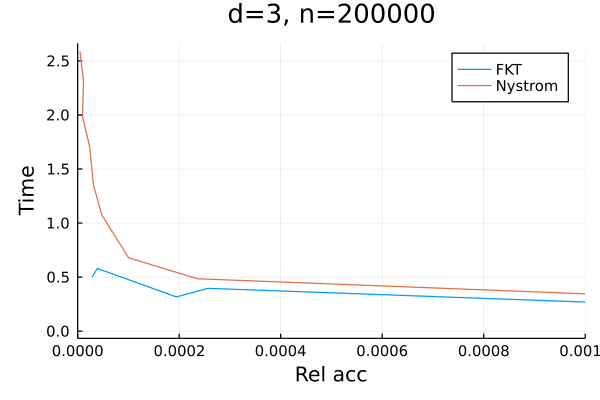

In [117]:
ps = fkt_degs
all_times = []
n = 200_000
d = 3

times = []
accs = []
ranks = []

for p in fkt_degs
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title="d=3, n=200000")

p = plot!(accs, times, xlabel="Rel acc", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_times[d], label="Nystrom", xlim=(0,0.001))


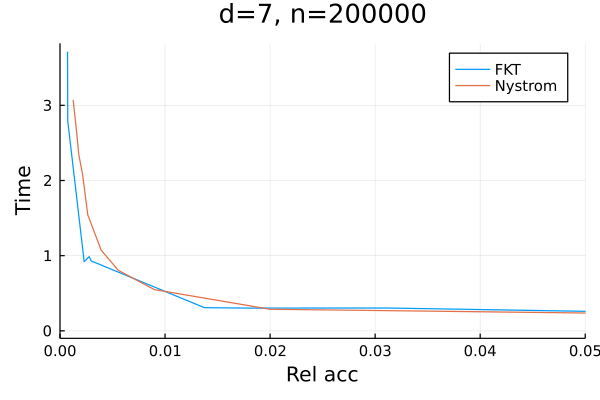

In [118]:
ps = fkt_degs
all_times = []
n = 200000
d = 7

times = []
accs = []

for p in fkt_degs
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
end
p = plot(title="d=7, n=200000")

p = plot!(accs, times, xlabel="Rel acc", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_times[d], label="Nystrom", xlim=(0,0.05))


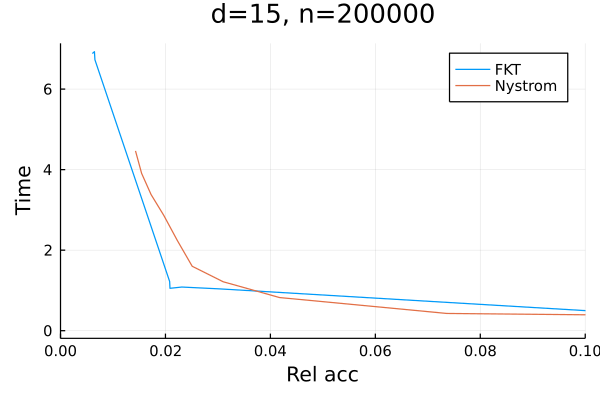

In [119]:
ps = fkt_degs
all_times = []
n = 200000
d = 15

times = []
accs = []

for p in fkt_degs
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
end
p = plot(title="d=15, n=200000")

p = plot!(accs, times, xlabel="Rel acc", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_times[d], label="Nystrom", xlim=(0,0.1))


In [87]:
# ns = collect(50000:50000:250000)
# d=3

# all_errs = []
# for p in fkt_degs
#     errs = []
#     for n in ns
#         push!(errs, results[(n, d, p)][3])
#     end
#     push!(all_errs, errs)
# end
# p = plot(title="d=3", thickness_scaling = 1.25, xlabel="N", ylabel="Rel err")
# for k in 1:length(all_errs)
#     p=plot!(ns, all_errs[k], label=string("p=",2*k))
# end
# p

In [88]:
# ns = collect(50000:50000:250000)
# d=3

# all_ranks = []
# for p in fkt_degs
#     ranks = []
#     for n in ns
#         push!(ranks, results[(n, d, p)][2])
#     end
#     push!(all_ranks, ranks)
# end
# p = plot(title="d=3", thickness_scaling = 1.25, xlabel="N", ylabel="Rank")
# for k in 1:length(all_ranks)
#     p=plot!(ns, all_ranks[k], label=string("p=",2*k))
# end
# p

In [89]:
# ns = collect(50000:50000:250000)
# d=7

# all_ranks = []
# for p in fkt_degs
#     ranks = []
#     for n in ns
#         push!(ranks, results[(n, d, p)][2])
#     end
#     push!(all_ranks, ranks)
# end
# p = plot(title=string("d=",d), thickness_scaling = 1.25, xlabel="N", ylabel="Rank")
# for k in 1:length(all_ranks)
#     p=plot!(ns, all_ranks[k], label=string("p=",2*k))
# end
# p

In [90]:
# n = 250_000
# ds = collect(3:4:15)
# all_ys = []
# for p in fkt_degs
#     ys = []
#     for d in ds
#         push!(ys, results[(n, d, p)][2])
#     end
#     push!(all_ys, ys)
# end
# p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="d", ylabel="Rank")
# for k in 1:length(all_ys)
#     p=plot!(ds, all_ys[k], label=string("p=",2*k))
# end
# p

In [91]:
# n = 250_000
# ds = collect(3:4:15)
# all_ys = []
# for p in fkt_degs
#     ys = []
#     for d in ds
#         push!(ys, results[(n, d, p)][3])
#     end
#     push!(all_ys, ys)
# end
# p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="d", ylabel="Rel err")
# for k in 1:length(all_ys)
#     p=plot!(ds, all_ys[k], label=string("p=",2*k))
# end
# p

In [92]:
# n = 250_000
# ds = collect(3:4:15)
# all_ys = []
# for p in fkt_degs
#     ys = []
#     for d in ds
#         push!(ys, results[(n, d, p)][1])
#     end
#     push!(all_ys, ys)
# end
# p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="d", ylabel="Time")
# for k in 1:length(all_ys)
#     p=plot!(ds, all_ys[k], label=string("p=",2*k))
# end
# p

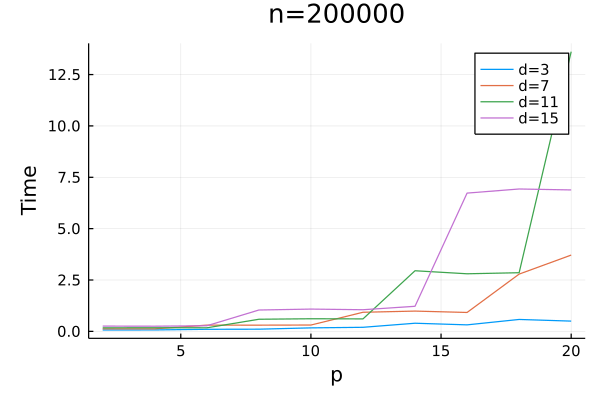

In [120]:
n = 200_000
ps = fkt_degs
all_ys = []
for d in 3:4:15
    ys = []
    for p in ps
        push!(ys, results[(n, d, p)][1])
    end
    push!(all_ys, ys)
end
p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="p", ylabel="Time")
for k in 1:length(all_ys)
    p=plot!(ps, all_ys[k], label=string("d=",4k-1))
end
p

In [93]:
# n = 250_000
# ps = fkt_degs
# all_ys = []
# for d in 3:4:15
#     ys = []
#     for p in ps
#         push!(ys, results[(n, d, p)][2])
#     end
#     push!(all_ys, ys)
# end
# p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="p", ylabel="Rank")
# for k in 1:length(all_ys)
#     p=plot!(ps, all_ys[k], label=string("d=",4k-1))
# end
# p

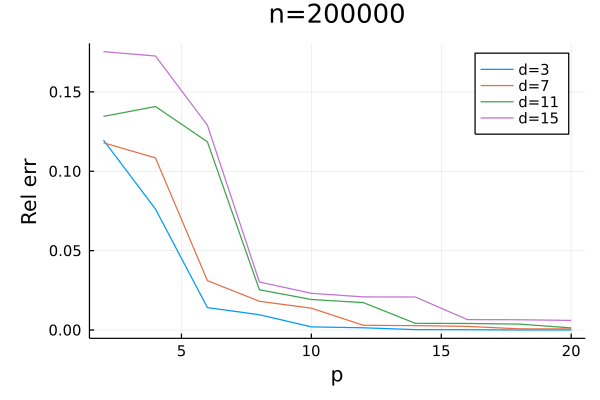

In [121]:
n = 200_000
ps = fkt_degs
all_ys = []
for d in 3:4:15
    ys = []
    for p in ps
        push!(ys, results[(n, d, p)][3])
    end
    push!(all_ys, ys)
end
p = plot(title=string("n=",n), thickness_scaling = 1.25, xlabel="p", ylabel="Rel err")
for k in 1:length(all_ys)
    p=plot!(ps, all_ys[k], label=string("d=",4k-1))
end
p

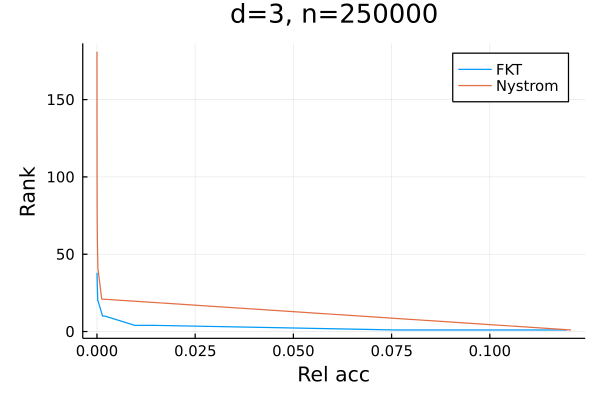

In [122]:
ps = fkt_degs
all_times = []
n = 200_000
d = 3

times = []
accs = []
ranks = []

for p in fkt_degs
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title="d=3, n=250000")

p = plot!(accs, ranks, xlabel="Rel acc", ylabel="Rank", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_ranks[d], label="Nystrom")


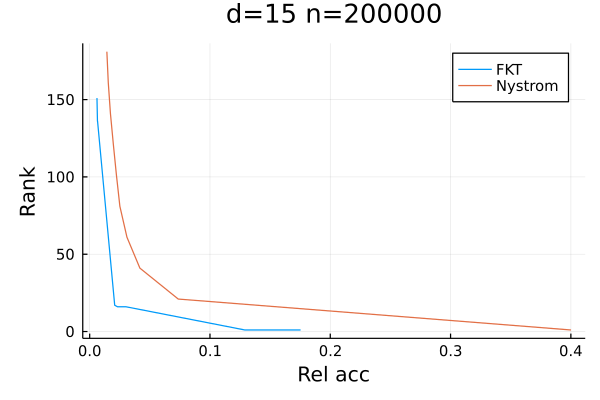

In [123]:
ps = fkt_degs
all_times = []
n = 200_000
d = 15

times = []
accs = []
ranks = []

for p in fkt_degs
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title=string("d=",d," n=", n))

p = plot!(accs, ranks, xlabel="Rel acc", ylabel="Rank", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_errs[d], d_to_nystrom_ranks[d], label="Nystrom")


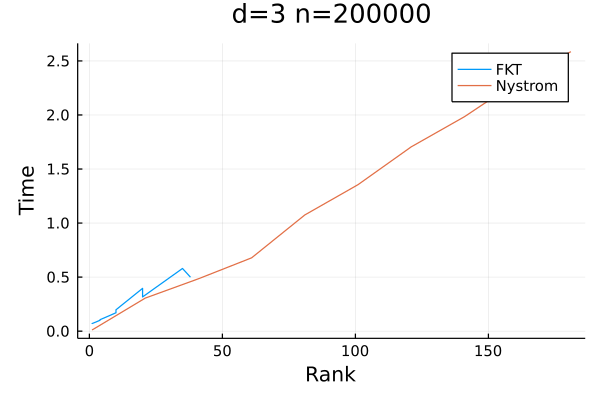

In [124]:
ps = fkt_degs
all_times = []
n = 200_000
d = 3

times = []
accs = []
ranks = []

for p in fkt_degs
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title=string("d=",d," n=", n))

p = plot!(ranks, times, xlabel="Rank", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_ranks[d], d_to_nystrom_times[d], label="Nystrom")


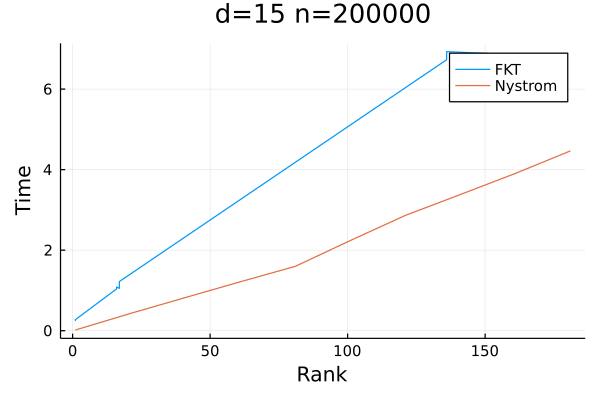

In [125]:
ps = fkt_degs
all_times = []
n = 200_000
d = 15

times = []
accs = []
ranks = []

for p in fkt_degs
    push!(times, results[(n, d, p)][1])
    push!(accs, results[(n, d, p)][3])
    push!(ranks, results[(n, d, p)][2])
end
p = plot(title=string("d=",d," n=", n))

p = plot!(ranks, times, xlabel="Rank", ylabel="Time", label="FKT", thickness_scaling = 1.25)
p = plot!(d_to_nystrom_ranks[d], d_to_nystrom_times[d], label="Nystrom")
